dfc["combatting"] = (dfc["thwack"] + dfc["musc"] + dfc["div"])/3

dfc["bhype"] = dfc["batting_team_hype"] * (1 + 0.2 *dfc["batter_vibes"])
dfc["phype"] = dfc["pitching_team_hype"] * (1 + 0.2 *dfc["batter_vibes"])
dfc["hypediff"] = dfc["phype"] - dfc["bhype"]

Season 12-19: 0.25 - 0.1*dfc["obtuseness"] + 0.1*dfc["forwardness"] + 0.1*dfc["combatting"] - 0.02*dfc["hypediff"]
Season 20-24: 0.25 - 0.1*dfc["obtuseness"] + 0.1*dfc["forwardness"] + 0.1*dfc["combatting"] - 0.013*dfc["hypediff"]


In [22]:
import load

df = load.data("fouls", season=20)


df["thwack_scaled"] = load.player_attribute(df, 'batter', 'thwackability', vibes=True, mods=True, items=True, broken_items=True)
df["musc_scaled"] = load.player_attribute(df, 'batter', 'musclitude', vibes=True, mods=True, items=True, broken_items=True)
df["div_scaled"] = load.player_attribute(df, 'batter', 'divinity', vibes=True, mods=True, items=True, broken_items=True)

    # center=True is the default
df["obtuseness"] = load.stadium_attribute(df, 'obtuseness', center=True)
df["forwardness"] = load.stadium_attribute(df, 'forwardness', center=True)


In [23]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [24]:
#df = df[(df["pitching_team_hype"] == 0) & (df["batting_team_hype"] == 0)]
#df = df[(df["batter_mul"] == 1) & (df["pitcher_mul"] == 1)]
dfc = df.copy()

for exclude_mod in []:
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["O_NO"]:
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["UNDEFINED", "MINIMIZED"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
#Cluttered not working correctly


for include_mod in []:
    dfc = dfc[dfc["batter_mods"].astype(str).str.contains(include_mod)]
for exclude_event in []:
    dfc = dfc[~dfc["event_type"].astype(str).str.contains(exclude_event)]
for exclude_day in []:
    dfc = dfc[~dfc["day"].astype(str).str.contains(exclude_day)]
for exclude_name in []:
    dfc = dfc[~dfc["batter_name"].astype(str).str.contains(exclude_name)]
dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

len(dfc)

25203

In [25]:
dfc["combatting"] = (dfc["thwack_scaled"] + dfc["musc_scaled"] + dfc["div_scaled"]) / 3


dfc["bhype"] = dfc["batting_team_hype"] * (1 + 0.2 *dfc["batter_vibes"]) 
dfc["phype"] = dfc["pitching_team_hype"] * (1 + 0.2 *dfc["batter_vibes"])


dfc["hypediff"] = dfc["phype"] - dfc["bhype"]

In [31]:
X = dfc[
    [
        "roll",
        "passed",
        "obtuseness",
        "forwardness",
        "combatting",
        "hypediff",
        #"bhype",
        #"phype"


    ]
].copy()
#X = X[X["forwardness"] > 0.5]
#X = X[X["roll"] < 0.86]
y = X["passed"]
y = y.astype('int')
X = X.drop(["passed"], axis=1)

pin_intercept = 0.25
pins = [ (0.1, "forwardness"),
        (-0.1, "obtuseness"),
        (0.1, "combatting"),
        (-0.013, "hypediff")
]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-15, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_   #- np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[16598     0]
 [    0  8605]]
0 outliers
1.0
0.25


[(1.0, 'roll')]

In [ ]:

dfc["threshold"] = 0.25 - 0.1*dfc["obtuseness"] + 0.1*dfc["forwardness"] + 0.1*dfc["combatting"] - 0.013*dfc["hypediff"]

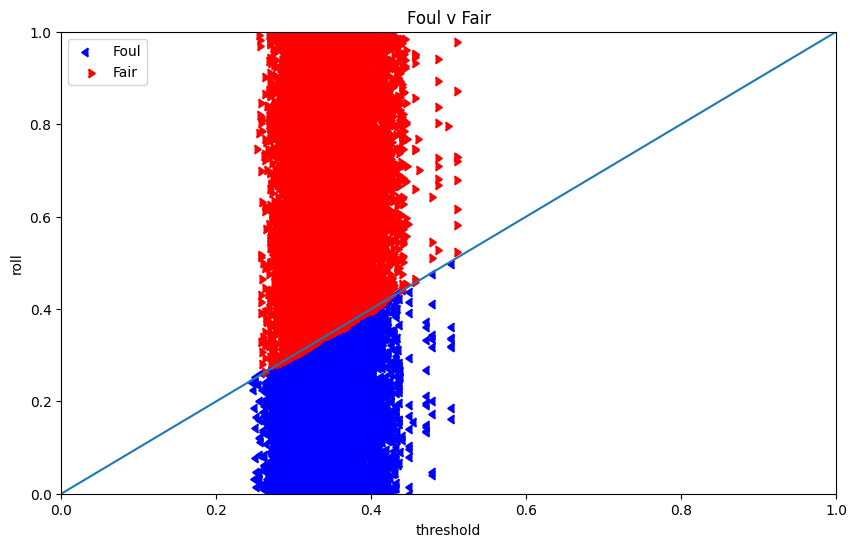

In [28]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed'].astype("bool")][x_val], dfc[dfc['passed'].astype("bool")]["roll"], color="blue",
           label="Foul", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed'].astype("bool")][x_val], dfc[~dfc['passed'].astype("bool")]["roll"], color="red",
           label="Fair", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Foul v Fair")
ax.set_xlim([0.0, 1])
ax.set_ylim([0.0, 1])
ax.legend()

,offset,event_type,roll,threshold,batter_name,pitcher_name,batter_mods,batting_team_mods,season,combatting,thwack_scaled,day,game_id,play_count
217,-0.004002,Fair,0.359384,0.363385,Alexander Horne,Durham Spaceman,,LOVE,20,0.881165,0.978211,2,1bbfe75b-ddd9-442a-bfef-cfbf017bd684,283
980,-0.003375,Fair,0.395729,0.399104,Gerund Pantheocide,Wesley Poole,EGO1,POPCORN_PAYOUTS,20,1.273668,1.591213,3,af90f8c0-aece-4bae-a9a1-69be69961d86,206
20902,-0.001867,Fair,0.363420,0.365287,Howell Franklin,Ankle Halifax,FLINCH,BASE_INSTINCTS,20,1.315160,1.175223,68,58ed6741-4339-448f-891f-90a6c8903ad9,34
5905,-0.001831,Fair,0.312981,0.314812,Fish Summer,Patchwork Southwick,FIRE_EATER,ACIDIC;SUN_KISSED;SUN2_PAYOUTS,20,0.905423,1.001574,8,0963b86c-e41a-45fa-8c7c-833f8da656d2,153
9085,-0.001387,Fair,0.373288,0.374675,Beasley Day,Ankle Halifax,PARASITE;MINIMALIST;PRO_SKATER,AA;AFFINITY_FOR_CROWS,20,1.170183,1.301996,56,d49f5dd2-cd13-482f-ab88-f0ec29704250,108
26394,-0.001328,Fair,0.357464,0.358792,Greer Lott,Elvis Figueroa,AMBITIOUS;OVERPERFORMING;NEGATIVE;ALTERNATE,HIGH_PRESSURE;MODERATION;LATE_TO_PARTY;H20,20,1.139173,1.111307,112,9ff7c456-1834-4525-b6de-7b7dda2943e6,164
10424,-0.001001,Fair,0.303940,0.304941,Siobhan Chark,Cell Barajas,FLICKERING;SWIM_BLADDER,PSYCHIC,20,0.742715,0.834838,57,43aa3ff0-705d-4e8e-ac8e-3b3a1d6c074e,203
21438,-0.000812,Fair,0.364474,0.365287,Howell Franklin,Ankle Halifax,FLINCH,BASE_INSTINCTS,20,1.315160,1.175223,68,58ed6741-4339-448f-891f-90a6c8903ad9,208
10807,-0.000688,Fair,0.354429,0.355117,Alexander Horne,Lucy Tokkan,,LOVE,20,0.881165,0.978211,58,2ec6f2c5-e379-44ab-9809-5357039e9cb5,15
7176,-0.000579,Fair,0.408170,0.408748,Tot Clark,Cell Barajas,AMBITIOUS,,20,1.335146,1.139937,54,617cc826-483a-4b76-8175-c62e2460d5e9,126


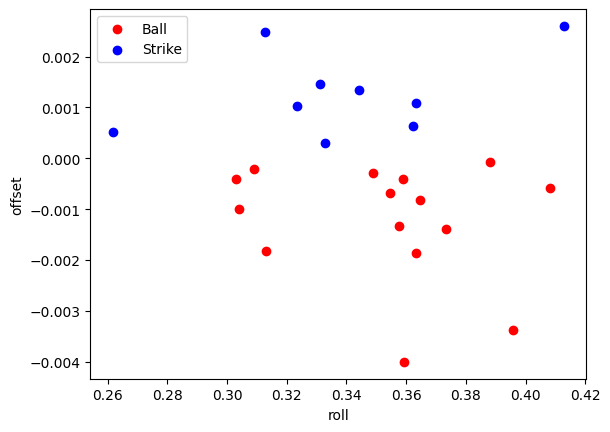

In [29]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
#outliers = outliers[outliers["threshold"] < 0.925]
outliers = outliers[outliers["combatting"] > 0.0]
#outliers = outliers[outliers["forwardness"] > 0.5]

fig, ax = plt.subplots(1)
x_val = "roll"
y_val = "offset"
ax.scatter(outliers[~outliers['passed'].astype("bool")][x_val], outliers[~outliers['passed'].astype("bool")][y_val], color="red", label="Ball")
ax.scatter(outliers[outliers['passed'].astype("bool")][x_val], outliers[outliers['passed'].astype("bool")][y_val], color="blue", label="Strike")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type",
       "roll", "threshold",
       "batter_name", "pitcher_name", "batter_mods", "batting_team_mods", "season", "combatting", "thwack_scaled", 
       "day",  "game_id", "play_count"]].sort_values('offset')


In [30]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.4970620322198573


KeyError: "None of [Index([-2, -1, -1, -1, -1, -1, -1, -1, -1, -2,\n       ...\n       -2, -1, -2, -1, -1, -2, -2, -1, -1, -1],\n      dtype='object', length=25203)] are in the [columns]"